In [2]:
import pandas as pd 
import numpy as np 


## Takeaways

### feature shape
- shape is possibly one of the most important parts of this process. When using scikit-learn you can abstract a lot of the math away. for example the softmax function is there and optimized in the library as is the normal equation and the training utilities 
- however understanding what shape your model is in before training can help avoid pitfalls in the process
- most importantly it is necessary to understand the target set and then normalize before training 

## Implement Batch Gradient descent with early stopping 

- not using sklearn 

In [3]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [18]:
X = iris['data'][:,(2, 3)] # petal length / width 
y = iris['target']

In [17]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [19]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

In [21]:
#train test split
test_ratio = .2
validation_ratio = .2
total_size = len(X_with_bias)
test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)


(90, 3)
(30, 3)
(30, 3)


#### To One hot 
- This transforms the non binary classifiers 0,1,2 to a one hot array 
- [1,0,0] / [0,1,0] / [0,0,1]
- 

In [29]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    Y_one_hot[np.arange(m), y] = 1
    return Y_one_hot


In [30]:
y_train[:10]

array([2, 1, 0, 0, 0, 2, 0, 1, 2, 2])

In [31]:
to_one_hot(y_train[:1])

array([[0., 0., 1.]])

In [32]:
y_train_one_hot = to_one_hot(y_train)
y_valid_one_hot = to_one_hot(y_valid)
y_test_one_hot = to_one_hot(y_test)

Softmax  
$\sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}$

In [33]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

In [35]:
n_inputs = X_train.shape[1] # == 3 (2 features plus the bias term)
n_outputs = len(np.unique(y_train))   # == 3 (3 iris classes)

In [37]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.randn(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    if iteration % 500 == 0:
        loss = -np.mean(np.sum(y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
        print(iteration, loss)
    error = Y_proba - y_train_one_hot
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 5.606901690376565
500 0.9467297657228496
1000 0.7501305324876758
1500 0.6417102687279281
2000 0.5733111369851128
2500 0.5255586117759691
3000 0.4897766854830227
3500 0.46158618540506935
4000 0.43854837985565803
4500 0.4191956426080267
5000 0.40258877956357836


In [38]:
Theta

array([[ 3.29947485, -0.41962197, -2.26007056],
       [-1.64321343, -0.59250468, -0.91605166],
       [-1.598468  , -0.21997328,  2.00412063]])

In [39]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

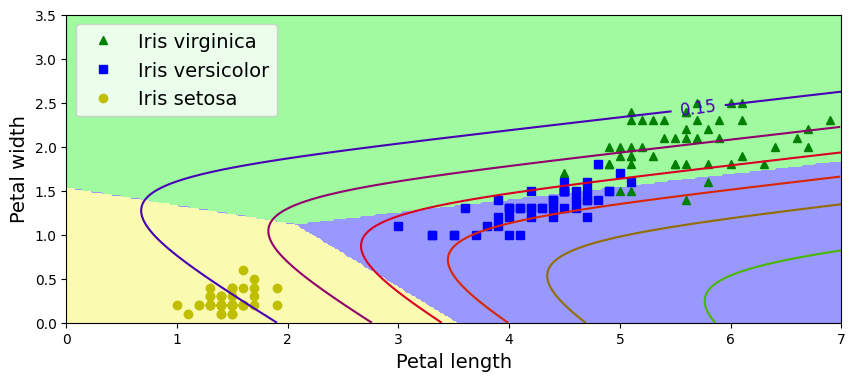

In [40]:
import matplotlib.pyplot as plt
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

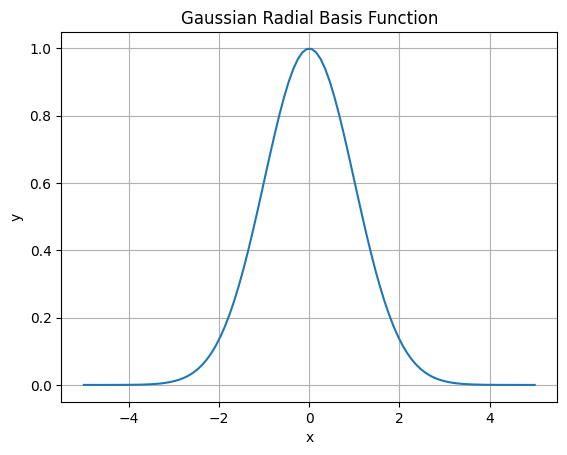

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_rbf(x, center, width):
    return np.exp(-0.5 * ((x - center) / width) ** 2)

# Define the parameters of the Gaussian RBF
center = 0.0
width = 1.0

# Generate x values
x = np.linspace(-5, 5, 100)

# Calculate the y values using the Gaussian RBF function
y = gaussian_rbf(x, center, width)

# Plot the Gaussian RBF
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gaussian Radial Basis Function')
plt.grid(True)
plt.show()
